## 1. CREACIÓN DEL DATASET

In [2]:
import pickle

In [ ]:
import os
import cv2
from tqdm import tqdm
import random as rn
import numpy as np

def Generar_datos():
    data = []
    
    for categoria in CATEGORIAS:
        path = os.path.join(DATADIR, categoria)
        valor = CATEGORIAS.index(categoria)
        listdir = os.listdir(path)
        for i in tqdm(range(len(listdir)), desc = categoria):
            imagen_nombre = listdir[i]
            try:
                imagen_ruta = os.path.join(path, imagen_nombre)
                imagen = cv2.imread(imagen_ruta, cv2.IMREAD_GRAYSCALE)
                imagen = cv2.resize(imagen,(IMAGE_SIZE, IMAGE_SIZE))
                data.append([imagen, valor])
            except Exception as e:
                pass
    rn.shuffle(data)
    x = []
    y = []

    for i in tqdm(range(len(data)),desc="Procesamiento"):
        par = data[i]
        x.append(par[0])
        y.append(par[1])

    x = np.array(x).reshape(-1,IMAGE_SIZE, IMAGE_SIZE,1)
    
    y = np.array(y)
    
    pickle_out = open("x.pickle","wb")
    pickle.dump(x, pickle_out)
    pickle_out.close()
    print("Archivo x.pickle creado!")

    pickle_out = open("y.pickle","wb")
    pickle.dump(y, pickle_out)
    pickle_out.close()
    print("Archivo x.pickle creado!")


CATEGORIAS = ['arma','knife']
IMAGE_SIZE = 100

if __name__ == "__main__":
    DATADIR = arma
    Generar_datos()

## 2. CARGAMOS LOS ARCHIVOS GENERADOS
<p>cargamos los archivos (x.pickle) y (y.pickle") y los asiganamos a X - y</p>

In [4]:
X = pickle.load(open("x.pickle","rb"))
y = pickle.load(open("y.pickle","rb"))

<p>importamos numpy</p>

In [5]:
import numpy as np

<p>Normalizar los datos de las X (imagenes). Se pasan a numero flotante y dividen entre 255 para quedar de 0-1 en lugar de 0-255<p/>

In [6]:
X = np.array(X).astype(float) / 255

<p>Convertios las etiquetas en un arreglo simple</p>

In [7]:
y = np.array(y)

In [8]:
X.shape

(4700, 100, 100, 1)

In [9]:
y.shape

(4700,)

<p>importamos matplotlib.pyplot</p>

In [10]:
import matplotlib.pyplot as plt

<p>vemos las imagenes de la variable X sin modificaciones por aumento de datos</p>

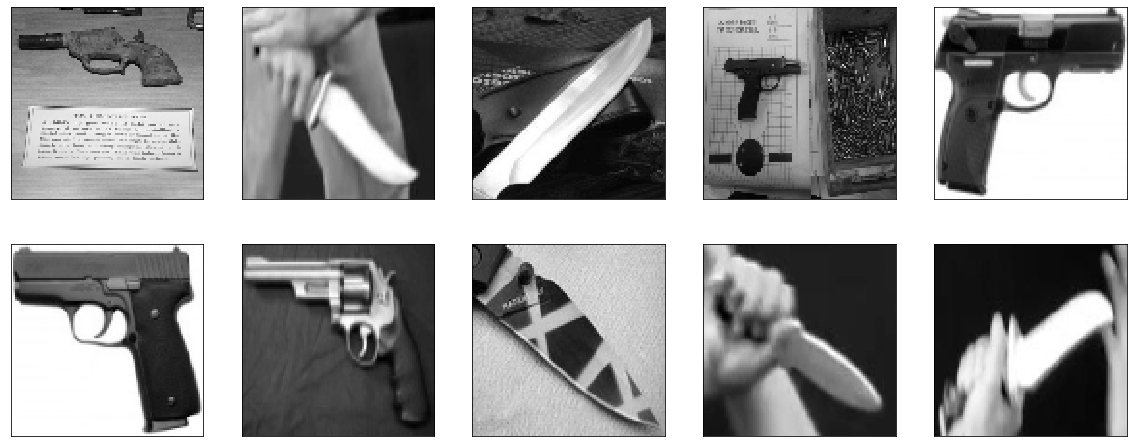

In [11]:
plt.figure(figsize=(20, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i].reshape(100, 100), cmap="gray")

<p>importamos TensorBoard</p>

In [12]:
from tensorflow.keras.callbacks import TensorBoard

##  3. Aumento de datos 

<p>Realizar el aumento de datos con varias transformaciones. graficamos 10 ejemploS</p>

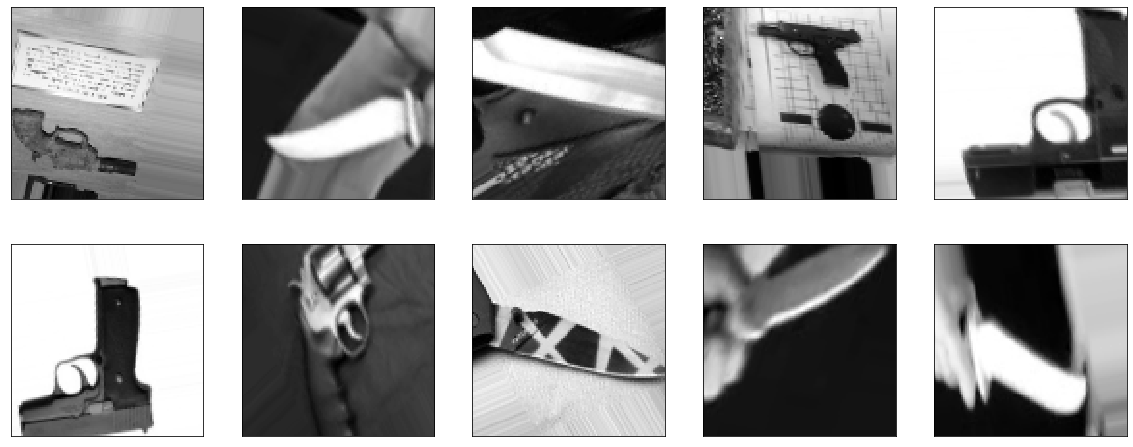

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=[0.7, 1.4],
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X)

plt.figure(figsize=(20,8))

for imagen, etiqueta in datagen.flow(X, y, batch_size=10, shuffle=False):
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(imagen[i].reshape(100, 100), cmap="gray")
    break

</p>importamos tensorflow</p>

In [14]:
import tensorflow as tf

## 4. Crear Red convolucional

In [ ]:
modeloCNN_AD = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN2_AD = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(250, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
modeloDenso_AD.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN_AD.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN2_AD.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

<p>Separamos los datos de entrenamiento y los datos de pruebas en variables diferentes</p>

In [ ]:
len(X) * .85 #3995

In [ ]:
len(X) - 3995 #705

In [ ]:
X_entrenamiento = X[:3995]
X_validacion = X[3995:]

y_entrenamiento = y[:3995]
y_validacion = y[3995:]

In [ ]:
# IMPORTAMOS TensorBoard
from tensorflow.keras.callbacks import TensorBoard

<p>Ejecutar tensorboard e indicarle que lea la carpeta "logs"</p>

In [ ]:
%tensorboard --logdir /content/logs

## logs

<img src="5.PNG" alt="">

<p>Usamos la funcion flow del generador para crear un iterador que podamos enviar como entrenamiento a la funcion FIT del modelo</p>

In [ ]:
data_gen_entrenamiento = datagen.flow(X_entrenamiento, y_entrenamiento, batch_size=32)

## 5. Entrenamos la red

In [ ]:
tensorboardDenso_AD = TensorBoard(log_dir='logs/denso_AD')

modeloDenso_AD.fit(
    data_gen_entrenamiento,
    epochs=100, batch_size=32,
    validation_data=(X_validacion, y_validacion),
    steps_per_epoch=int(np.ceil(len(X_entrenamiento) / float(32))),
    validation_steps=int(np.ceil(len(X_validacion) / float(32))),
    callbacks=[tensorboardDenso_AD]
)

<img src="1.PNG" alt="">

In [ ]:
tensorboardCNN_AD = TensorBoard(log_dir='logs/cnn_AD')

modeloCNN_AD.fit(
    data_gen_entrenamiento,
    epochs=150, batch_size=32,
    validation_data=(X_validacion, y_validacion),
    steps_per_epoch=int(np.ceil(len(X_entrenamiento) / float(32))),
    validation_steps=int(np.ceil(len(X_validacion) / float(32))),
    callbacks=[tensorboardCNN_AD]
)

<img src="2.PNG" alt="">

In [ ]:
tensorboardCNN2_AD = TensorBoard(log_dir='logs/cnn2_AD')

modeloCNN2_AD.fit(
    data_gen_entrenamiento,
    epochs=100, batch_size=32,
    validation_data=(X_validacion, y_validacion),
    steps_per_epoch=int(np.ceil(len(X_entrenamiento) / float(32))),
    validation_steps=int(np.ceil(len(X_validacion) / float(32))),
    callbacks=[tensorboardCNN2_AD]
)

<img src="3.PNG" alt="">

In [ ]:
modeloDenso_AD.save('weapon-knife-denso-ad.h5')

In [ ]:
modeloCNN_AD.save('weapon-knife-cnn-ad.h5')

In [ ]:
modeloCNN2_AD.save('weapon-knife-cnn2-ad.h5')

In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format keras weapon-knife-denso-ad.h5 /REDES_CONVUL/VERSION2/weapon-knife-denso

In [ ]:
!tensorflowjs_converter --input_format keras weapon-knife-cnn-ad.h5 /REDES_CONVUL/VERSION2/weapon-knife-cnn-ad

In [ ]:
!tensorflowjs_converter --input_format keras weapon-knife-cnn2-ad.h5 /REDES_CONVUL/VERSION2/weapon-knife-cnn2-add